### Building the dataset and pre-processing it
The dataset is the S&P500 companies' financial data from 2000 until 2024. I started building the dataset by acquiring the financial data from the yFinance library, which enables us to access the data available on Yahoo Finance. As the initial step, we will set up the list of the S&P 500 companies and download their daily adjusted close price and trading volume.

In [1]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

2024-02-20 17:29:19.665632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set up the list of the S&P500 companies
sp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500list = pd.read_html(sp500url)
sp500df = sp500list[0]
symbols = list(sp500df['Symbol'].values)
sp500df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [3]:
# Download daily data from 2000
df = yf.download(symbols,start='2000-01-01')

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-01 -> 2024-02-18)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


### Adjusting for failed downloads
As we can see tickers 'BRK.B' and 'BF.B' were not found in the yfinance library since yfinance and Wikipedia use different separators for these tickers (yfinance uses '-' instead of '.'). Therefore, we replace the tickers for these companies in the code cell below. 

In [4]:
# Fix for the failed downloads by updating the tickers 'BRK.B' and 'BF.B' with 'BRK-B' and 'BF-B' respectively
symbols[62] = 'BRK-B'
symbols[78] = 'BF-B'

In [5]:
# Fixed for BRK-B and BF-B
all_sp_500 = yf.download(symbols,start='2000-01-01') 

[*********************100%%**********************]  503 of 503 completed


In [6]:
subset_adjusted_close = all_sp_500['Adj Close']
subset_volume = all_sp_500['Volume']

In [7]:
# Create a panel dataframe from the adjusted close prices
panel_adjusted_close = subset_adjusted_close.reset_index().melt(id_vars='Date', var_name='Symbol', value_name='Adjusted Close')
# Create a panel dataframe from the volumes
panel_volume = subset_volume.reset_index().melt(id_vars='Date', var_name='Symbol', value_name='Volume')
panel_df = panel_adjusted_close.merge(panel_volume, on=['Date', 'Symbol'], how='inner')
# Merge the volume and adjusted close dataframes
merged_df = panel_df.merge(sp500df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']], on='Symbol', how='left')

In [8]:
# Now let's import the CEO dismissal data
dismissal = pd.read_csv('CEO_Dismissal_Database_9Nov23.csv')
dismissal

,dismissal_dataset_id,coname,gvkey,fyear,co_per_rol,exec_fullname,departure_code,ceo_dismissal,interim_coceo,tenure_no_ceodb,left_ceo_office,date_departure_announced,notes,sources,eight_ks
0,1,AAR CORP,1004,1995,5622,Ira A. Eichner,5.0,0.0,NaN,1,10/1/1996,7/9/1996,Mr. Ira A. Eichner served as CEO until October...,https://www.comparably.com/companies/aar-corp/...,NaN
1,2,AAR CORP,1004,2017,5623,David P. Storch,5.0,0.0,NaN,1,5/31/2018,1/9/2018,Agreed to stay as non-executive chairman post ...,https://advance-lexis-com.umiss.idm.oclc.org/a...,https://www.sec.gov/Archives/edgar/data/1750/0...
2,4,ADC TELECOMMUNICATIONS INC,1013,2000,2611,William J. Cadogan,5.0,0.0,NaN,1,2/15/2001,5/18/2000,Changed to 5. The transition was widely traile...,https://www.lightreading.com/adc-names-new-top...,https://www.sec.gov/Archives/edgar/data/61478/...
3,5,ADC TELECOMMUNICATIONS INC,1013,2003,23275,Richard R. Roscitt,6.0,0.0,NaN,1,8/13/2003,8/13/2003,"Richard R. ""Rick"" Roscitt has accepted a new p...","Steve Alexander; Staff Writer. (August 14, 200...",https://www.sec.gov/Archives/edgar/data/61478/...
4,6,ADC TELECOMMUNICATIONS INC,1013,2010,8741,Robert E. Switz,7.0,0.0,NaN,1,12/1/2010,7/14/2010,"Robert E. Switz was the chairman, president an...",https://www.micron.com/about/our-company/leade...,https://www.sec.gov/Archives/edgar/data/61478/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8887,10422,ORACLE CORP,12142,2018,44443,Mark Vincent Hurd,1.0,0.0,CO-CEO,2,10/18/2019,NaN,He passed away suddenly leaving Safra as sole ...,https://en.wikipedia.org/wiki/Mark_Hurd\nhttps...,https://www.sec.gov/Archives/edgar/data/134143...
8888,10423,MILLER (HERMAN) INC,7401,2003,10366,Michael A. Volkema,5.0,0.0,NaN,1,7/1/2004,6/23/2004,Mr. Volkema has been Chairman of the Board of ...,https://markets.on.nytimes.com/research/stocks...,https://www.sec.gov/Archives/edgar/data/66382/...
8889,10424,HARSCO CORP,5496,2014,50513,David C. Everitt,7.0,0.0,INTERIM,1,7/31/2014,7/31/2014,"David C. Everitt, a director of the Company, b...",https://www.sec.gov/Archives/edgar/data/45876/...,https://www.sec.gov/Archives/edgar/data/45876/...
8890,10425,COMPUTER TASK GROUP INC,3342,2014,32935,Brendan M. Harrington,7.0,0.0,INTERIM,1,3/13/2015,NaN,NaN,https://investors.ctg.com/news-releases/news-r...,https://www.sec.gov/Archives/edgar/data/23111/...


In [9]:
codes = pd.read_csv('codes - Sheet2.csv')

### Standardize the variables and merge the data
We can't merge the two data frames directly since the name column in the dismissal dataset is not in the same format as 
the Security column in the financial dataset. Therefore, we need to standardize the "coname" column in the dismissal dataset to match the Security column in the financial dataset. One way to do this is to use a third dataset with both the gvkey and standardized tickers for the corresponding gvkey. We will (1) import this dataset and merge it with the dismissal data on "gvkey" to get the standardized tickers. Then (2) we can link the financial data with the dismissal data on the standardized tickers. 

In [10]:
# Standardize the company tickers in dismissal data
codes = codes.rename(columns={"Compustat gvkey":"gvkey"})
standardized_names = dismissal.merge(codes[["gvkey","Compustat name","CRSP ticker"]],on="gvkey",how="left")
# Check how many unique companies we have left in the dismissal data
standardized_names = standardized_names.rename(columns={"CRSP ticker":"Symbol"})
standardized_names["Compustat name"].nunique() 

462

### Exploratory data analysis
Let's conduct some exploratory data analysis and visualize the financial data.

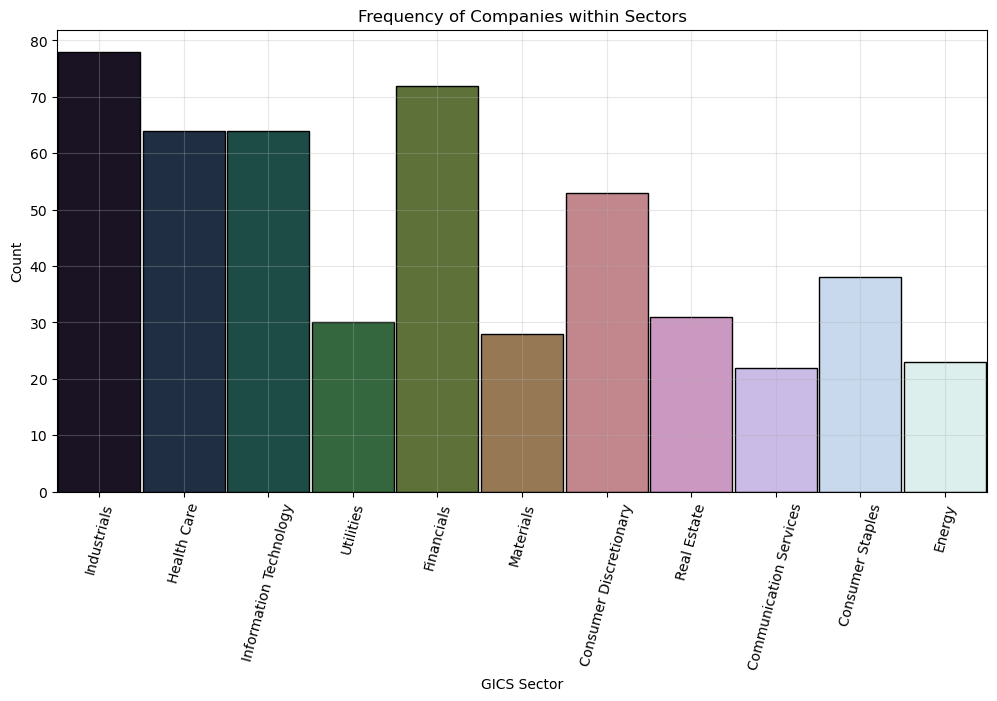

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=sp500df, x='GICS Sector', palette='cubehelix', edgecolor='black', linewidth=1, width=0.97)
plt.xlabel('GICS Sector')
plt.ylabel('Count')
plt.title('Frequency of Companies within Sectors')
plt.xticks(rotation=75)
plt.grid(alpha=0.3)
plt.show()

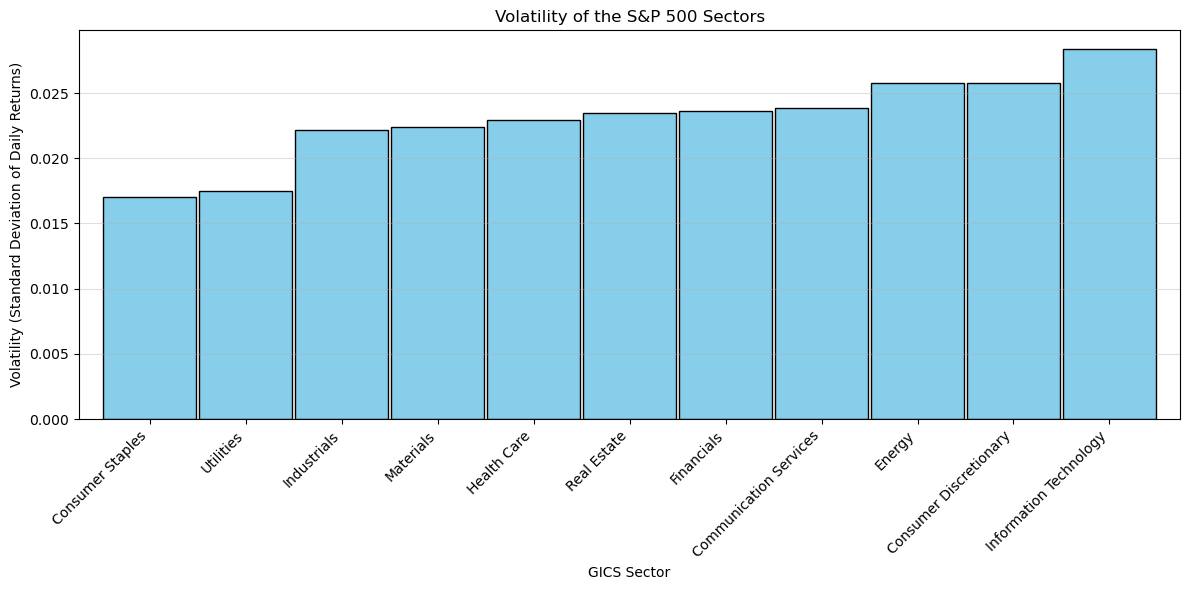

In [12]:
merged_df['Daily Return'] = merged_df.groupby('Symbol')['Adjusted Close'].pct_change()
volatility_by_sector = merged_df.groupby('GICS Sector')['Daily Return'].std().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
volatility_by_sector.sort_values().plot(kind='bar', color='skyblue', edgecolor='black', linewidth=1, width=0.97)
plt.xlabel('GICS Sector')
plt.ylabel('Volatility (Standard Deviation of Daily Returns)')
plt.title('Volatility of the S&P 500 Sectors')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


As we can see the most volatile sectors are Information Technology, Consumer Discretionary, and Energy. However, the difference between the sectors is not that significant.

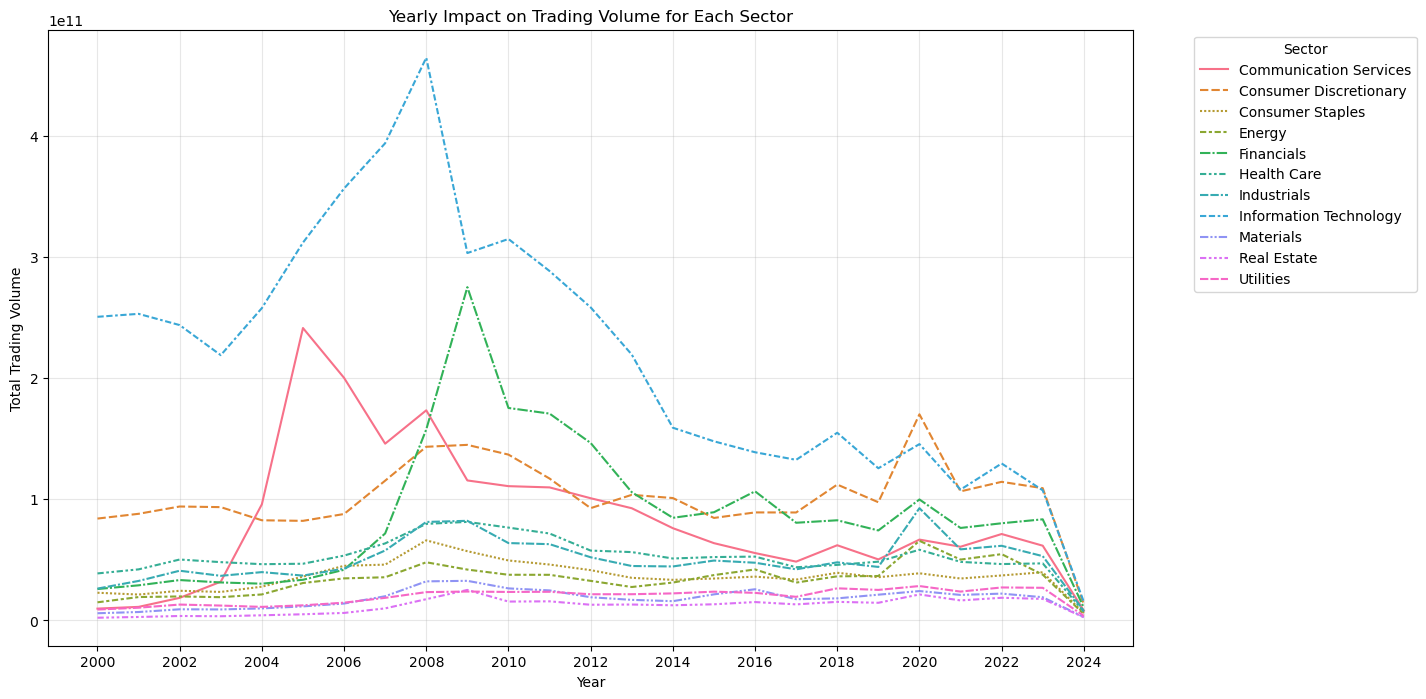

In [13]:
# Group yearly volumes by sector to see how the trading volume has changed over the years
volume_by_sector = merged_df.groupby('GICS Sector')['Volume'].sum().sort_values(ascending=False)
merged_df["Year"] = merged_df["Date"].dt.year
volume_by_sector_yearly = merged_df.groupby(['GICS Sector', "Year"])['Volume'].sum().unstack()

# Visualize the change in trading volume over the years for each sector
plt.figure(figsize=(14, 8))
sns.lineplot(data=volume_by_sector_yearly.T, linewidth=1.5)
plt.title('Yearly Impact on Trading Volume for Each Sector')
plt.xlabel('Year')
plt.ylabel('Total Trading Volume')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(min(merged_df["Year"]), max(merged_df["Year"])+1, 2))  
plt.grid(alpha=0.3)
plt.show()

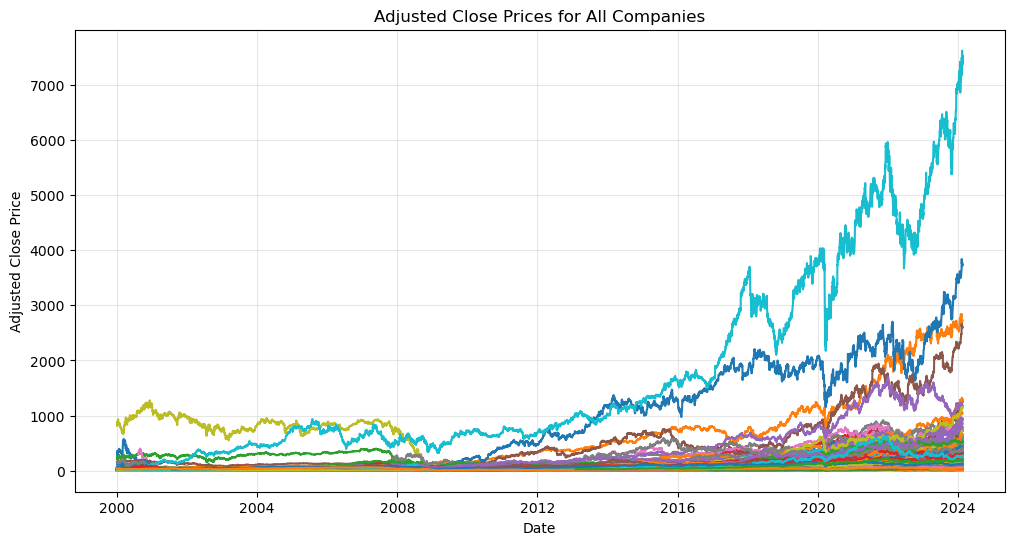

In [14]:
# Plot the prices to visualize if there are any significant breaks in the adjusted close prices
plt.figure(figsize=(12, 6))
for symbol in symbols:
    plt.plot(merged_df[merged_df['Symbol'] == symbol]['Date'], merged_df[merged_df['Symbol'] == symbol]['Adjusted Close'], label=symbol)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Prices for All Companies')
plt.grid(alpha=0.3)
plt.show()


In [15]:
merged_df.to_csv('merged_df.csv', index=False)